In [3]:
from IPython import get_ipython
import numpy as np
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
import librosa.display
import pylab
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.metrics import accuracy_score , plot_confusion_matrix
from sklearn import svm
from sklearn.decomposition import PCA
import librosa    
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
import tensorflow.keras as keras
import pandas as pd
from pylab import rcParams
import random
import time
from tqdm import tqdm
import IPython.display as ipd

rcParams['figure.figsize'] = 20, 5
#get_ipython().run_line_magic('matplotlib', 'inline')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
else:
    print("There are not GPUs avaliable")
# Auxiliar FUNC
def plot_confusion_matrix_custom(title, classifier, X_test, y_test, class_names, normalize = None):
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.show()


There are not GPUs avaliable


In [454]:
## Data aumentation
#http://dcase.community/documents/workshop2019/proceedings/DCASE2019Workshop_Inoue_20.pdf
audio_data = []
labels = []
sampling_rate = []
file_names = []
classes = []
label_number=0
audio_data = []
labels = []
sampling_rate = []
file_names = []
data = []
noisy_removed=[]
noise=[]
samplerate = 44000
max_leng=0 # mínima cantidad de muestras por sonido
sound_duration = 4 # se desea que todas las muestren duren 4 segundos y se las fuerza a serlo
max_leng = int(sound_duration*samplerate)
break_points     = [i for i in range(0,max_leng,int(max_leng/int(sound_duration)) )] # posición en tiempo discreto
break_points[-1] = max_leng
mult_generaciones = 5
random_state=10

def swap_audio_seconds(audio, audio_2, break_points, random_state = 2, half = True):
    random.seed(random_state)
    max_leng = break_points[-1]
    positions = [i for i in range(0,len(break_points)-1)]
    random.shuffle(positions)
    #print(positions)
    def append_sound_parts(audio,audio_2,break_points,positions,ind):
        sound_temp = []
        if ind == len(positions)-1:
            return audio[break_points[positions[ind]]:break_points[positions[ind]+1]]
        elif ind%2 == 0:
            peace2add = audio_2[break_points[positions[ind]]:break_points[positions[ind]+1]]
            return np.append( peace2add if np.max(np.abs(peace2add)) >= 0.25 else audio[break_points[positions[ind]]:break_points[positions[ind]+1]] ,append_sound_parts(audio,audio_2,break_points,positions,ind+1) )
        else:
            return np.append(audio[break_points[positions[ind]]:break_points[positions[ind]+1]],append_sound_parts(audio,audio_2,break_points,positions,ind+1) )
    def swap_half_position(max_leng):
        return np.append(audio[int(max_leng/2):], audio[:int(max_leng/2)]) 
    
    return swap_half_position(max_leng) if half else append_sound_parts(audio,audio_2,break_points,positions,0)

for filepath in glob.iglob('dataset/*'):
    #print(filepath[9:])
    #print(filepath)
    classes.append(filepath[8:])
print(classes)

for i in classes:
    print("the class = "+i+", the label = "+str(label_number))
    for ind, sound_file in tqdm( enumerate(glob.iglob('dataset/'+i+'/*'))):
        #samplerate, data = wavfile.read(j)
        #print(sound_file)
        i_sound, s = librosa.load(sound_file, sr=samplerate) # Downsample 44.1kHz
        i_sound = i_sound[:max_leng] if len(i_sound) > max_leng else np.pad(i_sound, (0,max_leng-len(i_sound)), constant_values = (0,0)) #padding or cut
        audio_2 = audio_data[-(mult_generaciones+1)] if ind > mult_generaciones else swap_audio_seconds(i_sound,i_sound,break_points,half=False, )
        audio_data.append(i_sound)
        _= [audio_data.append(swap_audio_seconds(i_sound,audio_2,break_points,half=False, random_state=i )*np.power(10, random.uniform(-10, 10) / 20.0)) for i in range(random_state,random_state+mult_generaciones)]
        _= [labels.append(label_number) for _ in range(0,mult_generaciones+1)]
        #samplesize = len(y)
        #reduced_noise = nr.reduce_noise(audio_clip=y, noise_clip=y, verbose=False)
        #print(s)
        #print(j)
        #audio_data.append(i_sound)
        #max_leng = samplesize if samplesize>max_leng else max_leng
        #noise.append(y)
        #labels.append(label_number)

    label_number = label_number + 1
    print("Cantidad máxima de muestras / Sonido / clase: ", max_leng)
print("Cantidad máxima de muestras / Sonido: ", max_leng)
print(label_number)


1it [00:00,  5.95it/s]

['001 - Dog bark', '002 - Rain', '003 - Sea waves', '004 - Baby cry', '005 - Clock tick', '006 - Person sneeze', '007 - Helicopter', '008 - Chainsaw', '009 - Rooster', '010 - Fire crackling']
the class = 001 - Dog bark, the label = 0


40it [00:06,  5.84it/s]
0it [00:00, ?it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 002 - Rain, the label = 1


40it [00:06,  5.78it/s]
1it [00:00,  6.02it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 003 - Sea waves, the label = 2


40it [00:06,  5.93it/s]
1it [00:00,  6.06it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 004 - Baby cry, the label = 3


40it [00:06,  5.88it/s]
1it [00:00,  5.88it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 005 - Clock tick, the label = 4


40it [00:06,  5.82it/s]
1it [00:00,  6.25it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 006 - Person sneeze, the label = 5


40it [00:06,  5.99it/s]
1it [00:00,  5.98it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 007 - Helicopter, the label = 6


40it [00:06,  5.80it/s]
1it [00:00,  5.68it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 008 - Chainsaw, the label = 7


40it [00:06,  5.84it/s]
1it [00:00,  6.13it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 009 - Rooster, the label = 8


40it [00:06,  5.90it/s]
1it [00:00,  5.98it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 010 - Fire crackling, the label = 9


40it [00:06,  5.79it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
Cantidad máxima de muestras / Sonido:  176000
10


In [445]:
np.stack([.5,1,2.5,.6])*np.power(10, random.uniform(-10, 10) / 20.0)

array([1.28638695, 2.5727739 , 6.43193475, 1.54366434])

Duración:  4 s
SampleTime: 0.000023s 
Cantidad de muestras:  176000


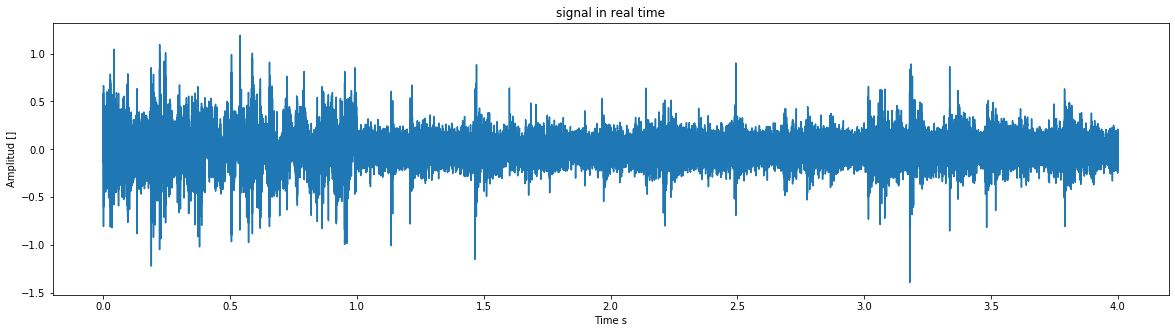

Dimención de la STFT:  (513, 344)
Clase:  002 - Rain
Windowing Time:  0.02327272727272727 s
tiempo de ejecución STFT: 14.007807 uS


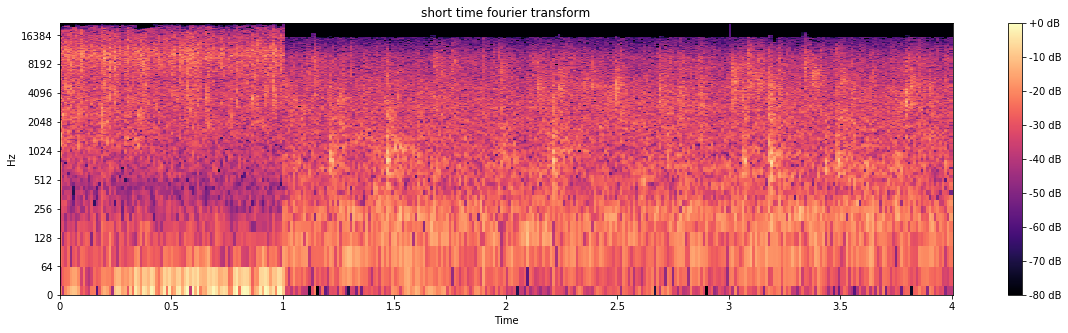

In [464]:
# ANALIZANDO UNA MUESTRA 
example = 478
#sound_duration = 4 # se desea que todas las muestren duren 4 segundos y se las fuerza a serlo
max_leng = int(sound_duration*samplerate)
step = sound_duration/max_leng
print("Duración: ", sound_duration,"s")
print("SampleTime: {:6f}s ".format(step))
# Se completa con ceros hasta alcanzar la longitud igual para todas las muestras
data_sound = audio_data[example][:max_leng] if len(audio_data[example]) > max_leng else np.pad(audio_data[example], (0,max_leng-len(audio_data[example])), constant_values = (0,0))
# Visualizando Sonido en el Tiempo vs Amplitud
save_path= 'tiempoVSamp.jpg'
print("Cantidad de muestras: ",len(data_sound))
plt.plot([step*i for i in range(len(data_sound))],data_sound)
plt.xlabel('Time s')
plt.ylabel('Amplitud []')
plt.title('signal in real time')
pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
plt.show()
#pylab.close()

# Analizando Sonido ZTiempo vs Coef STFT
time_init = time.time()
rcParams['figure.figsize'] = 20, 5
n_fft = 1024 # n_fft/2+1 como la cantidad de bandas a descomponer en el espectro de frecuencia
win_length=1024 # Ventaneo de la STFT
hop_length=int(win_length/2) # Desplazamiento de la ventana de transformación
freq = librosa.amplitude_to_db(np.abs(librosa.stft(data_sound,n_fft=n_fft, win_length=win_length ,hop_length=hop_length)), ref=np.max) #Se obtiene la potencia de la transformada 
print("Dimención de la STFT: ", freq.shape)
print("Clase: ",classes[labels[example]])
print("Windowing Time: ", win_length*1/samplerate,"s")
time_final = time.time()
data = (time_final- time_init )/1000
print("tiempo de ejecución STFT: {:2f} uS".format(data*10**6))
save_path2 = 'SFTF_'+save_path
#plt.axis('off') # no axis
librosa.display.specshow(freq,hop_length=hop_length,x_axis='time', y_axis='log',sr=44000, )
plt.colorbar(format='%+2.0f dB')
plt.title('short time fourier transform')
pylab.savefig(save_path2, bbox_inches=None, pad_inches=0)
#pylab.close()
ipd.Audio(data_sound, rate=samplerate) # load a NumPy array

In [465]:
# Aplicando STFT a todas las muestras de sonido
X_stft = []
Y_label=[]
cant_samples = max_leng
for i, i_sound in tqdm(enumerate(audio_data)):
    #i_sound = i_sound[:cant_samples] if len(i_sound) > cant_samples else np.pad(i_sound, (0,cant_samples-len(i_sound)), constant_values = (0,0))
    coef_stft = librosa.amplitude_to_db(np.abs(librosa.stft(i_sound, n_fft=n_fft, win_length=win_length ,hop_length=hop_length)), ref=np.max)
    stft_shape = coef_stft.shape
    #freq = np.abs(librosa.stft(audio_data[i], n_fft=512, hop_length=256, win_length=512))
    freq=coef_stft.reshape(-1,1)
    X_stft.append(freq)
    Y_label.append(labels[i])
    # if freq.shape[0]>=cant_samples:
    #     X_stft.append(freq[:cant_samples])
    #     Y_label.append(labels[i])
    
X_stft =np.stack(X_stft) 
X_stft.shape
X_stft=X_stft.reshape(len(audio_data),-1)
X_stft.shape


2400it [00:26, 90.87it/s]


(2400, 176472)

In [469]:
# Normalizando datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_stft,y = X_stft)
normalized_stft = scaler.transform(X_stft)
print(np.amax(X_stft))
print(np.amax(normalized_stft))

# Dividiendo lasmuestras de forma homogenea
#from skmultilearn.model_selection import iterative_train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_stft,Y_label, test_size=0.20,random_state =50,stratify= Y_label)
print("Split ready")


3.8146973e-06
1.0000076
Split ready


[LibSVM]SVM: acc:0.9625


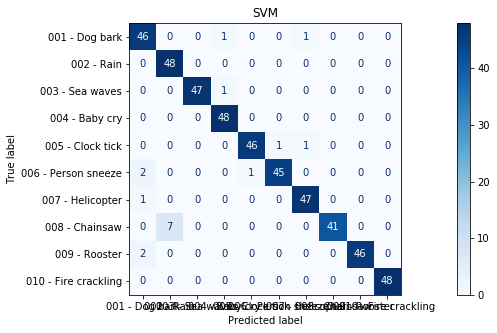

In [467]:
#Modelo con SVM
clf = svm.SVC(verbose= True,random_state=150,C=10, kernel='linear', gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("SVM: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix_custom(title = "SVM", 
                            classifier=clf, 
                            X_test=X_test, 
                            y_test = y_test,
                            class_names =  classes,
                            normalize =None)

Cantidad de caracteristicas 176472
[LibSVM]SVM+PCA: acc:0.9729166666666667


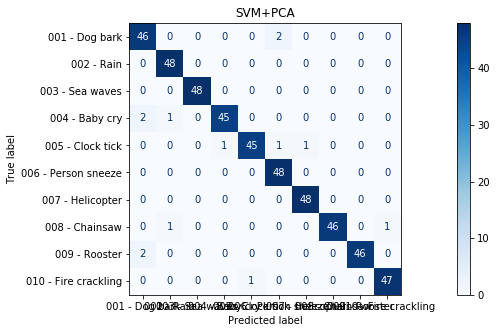

In [470]:
# Modelo con PCA y SVM
print("Cantidad de caracteristicas", len(X_stft[0]))
pca = PCA(n_components=2400)
pca.fit(normalized_stft) ## justa para todo el espectro de datos
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)
clf_PCA = svm.SVC(verbose= True,random_state=None,C=10, kernel='linear', gamma='scale', probability=True )
clf_PCA.fit(X_train_PCA, y_train)
y_pred = clf_PCA.predict(X_test_PCA)
print("SVM+PCA: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix_custom(title = "SVM+PCA", 
                            classifier=clf_PCA, 
                            X_test=X_test_PCA, 
                            y_test = y_test,
                            class_names =  classes,
                            normalize =None)

In [ ]:
# Modelo clasificador con XGB & PCA
xgb_model = XGBClassifier(learning_rate=0.01,
                    n_estimators=1200,
                    max_depth=100,
                    min_child_weight=.05,
                    gamma=0,
                    subsample=.5,
                    colsample_bytree=0.5,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=10,
                    num_parallel_tree = 18,
                    seed=27,verbosity= 1,n_jobs=8 )
xgb_model.fit(X_train_PCA, y_train)
#xgb_model.save_model('models/xgbmodel')
y_pred = xgb_model.predict(X_test_PCA)
print("XGB+PCA: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix_custom(title = "XGB+PCA", 
                            classifier=xgb_model, 
                            X_test=X_test_PCA, 
                            y_test = y_test,
                            class_names =  classes,
                            normalize =None)

In [ ]:
# Preparando datos para la CNN
X_train_NN= np.reshape(X_train,(X_train.shape[0],stft_shape[0], -1,1))
X_test_NN = np.reshape(X_test,(X_test.shape[0],stft_shape[0], -1,1))
y_train_NN=keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
y_test_NN =keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')


In [ ]:
# Compra para compra de proyecto de IVA
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=X_train_NN.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))#input_shape=features.shape[1:]
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32))#input_shape=features.shape[1:]
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('softmax'))
#sgd = optimizers.SGD(lr=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4),
              metrics=['accuracy'])
model.summary()
n_epochs = 0
#tf.keras.utils.plot_model(model, to_file='NN_model.jpg', show_shapes=True)


In [ ]:
# %% 
# Entrenando modelo Deep learning
logdir="logs2" 
epoch_add = 20
tboard_callback = TensorBoard(log_dir=logdir)
history = model.fit(X_train_NN, y_train_NN,
                    #steps_per_epoch = 8,   #cantidad de veces que se calculará el gradiente |DATOStotale = steps_per_epoch * batch_size
                    batch_size=8,          #cantidad de muestras para calcular el gradiente
                    epochs=n_epochs+epoch_add,
                    initial_epoch = n_epochs,
                    callbacks=[tboard_callback],
                    validation_data = (X_test_NN,y_test_NN))

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0) 
plt.figure()
plt.show()
